<a href="https://colab.research.google.com/github/SagarJiyani-Cilans/Super-Resolution-GANs/blob/main/SRGAN/Notebooks/SRGAN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Downloading

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d akhileshdkapse/super-image-resolution

In [ ]:
! unzip super-image-resolution.zip -d /content/drive/MyDrive/ColabNotebooks/GANs/SRGAN/

# Libraries

In [1]:
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import math
from torchvision.models.vgg import vgg16
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

torch.autograd.set_detect_anomaly(True)

# Generator

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2      

if __name__ == '__main__':
    rb = Generator(4)
    print(rb)

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

# Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

if __name__ == '__main__':
    disc = Discriminator()
    print(disc)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

# Loss FUnctions

In [4]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


if __name__ == "__main__":
    g_loss = GeneratorLoss()
    print(g_loss)

GeneratorLoss(
  (loss_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

# Config

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIR = '/content/drive/MyDrive/ColabNotebooks/GANs/SRGAN/Data/LR'
TARGET_DIR = '/content/drive/MyDrive/ColabNotebooks/GANs/SRGAN/Data/HR'
UPSCALE_FACTOR = 4
CROP_SIZE = 88
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
NUM_WORKERS = 4
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:4], nrow=4)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Dataset

In [6]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class ValDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDatasetFromFolder, self).__init__()
        self.lr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/data/'
        self.hr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/target/'
        self.upscale_factor = upscale_factor
        self.lr_filenames = [join(self.lr_path, x) for x in listdir(self.lr_path) if is_image_file(x)]
        self.hr_filenames = [join(self.hr_path, x) for x in listdir(self.hr_path) if is_image_file(x)]

    def __getitem__(self, index):
        image_name = self.lr_filenames[index].split('/')[-1]
        lr_image = Image.open(self.lr_filenames[index])
        w, h = lr_image.size
        hr_image = Image.open(self.hr_filenames[index])
        hr_scale = Resize((self.upscale_factor * h, self.upscale_factor * w), interpolation=Image.BICUBIC)
        hr_restore_img = hr_scale(lr_image)
        return image_name, ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.lr_filenames)

# Training

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[0/500] Loss_D: 0.9847 Loss_G: 0.0861 D(x): 0.4743 D(G(z)): 0.4098: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


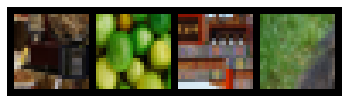

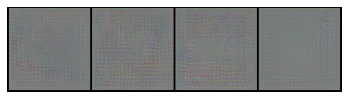

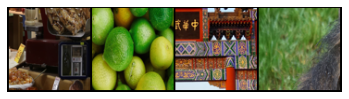

[1/500] Loss_D: 0.8975 Loss_G: 0.0715 D(x): 0.5136 D(G(z)): 0.3643: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[2/500] Loss_D: 0.8278 Loss_G: 0.0461 D(x): 0.5481 D(G(z)): 0.3142: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
[3/500] Loss_D: 0.7588 Loss_G: 0.0338 D(x): 0.5633 D(G(z)): 0.2742: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
[4/500] Loss_D: 0.7166 Loss_G: 0.0347 D(x): 0.5576 D(G(z)): 0.2577: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
[5/500] Loss_D: 0.7798 Loss_G: 0.0314 D(x): 0.6084 D(G(z)): 0.2551: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
[6/500] Loss_D: 0.6919 Loss_G: 0.0282 D(x): 0.5821 D(G(z)): 0.2345: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
[7/500] Loss_D: 0.7223 Loss_G: 0.0272 D(x): 0.6021 D(G(z)): 0.2221: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
[8/500] Loss_D: 0.7164 Loss_G: 0.0273 D(x): 0.5759 D(G(z)): 0.2834: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]
[9/500] Loss_D: 0.5940 Loss_G: 0.0248 D(x): 0.6541 D(G(z)): 0.2075: 100%|██████████| 2/2

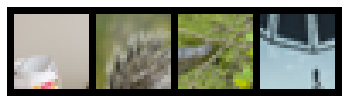

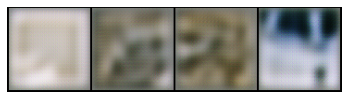

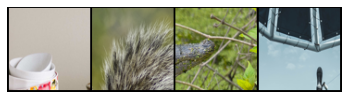

[11/500] Loss_D: 0.6004 Loss_G: 0.0242 D(x): 0.7774 D(G(z)): 0.2599: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[12/500] Loss_D: 0.4732 Loss_G: 0.0234 D(x): 0.7386 D(G(z)): 0.1791: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[13/500] Loss_D: 0.4107 Loss_G: 0.0219 D(x): 0.8451 D(G(z)): 0.1827: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[14/500] Loss_D: 0.3610 Loss_G: 0.0227 D(x): 0.7943 D(G(z)): 0.1337: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[15/500] Loss_D: 0.3318 Loss_G: 0.0215 D(x): 0.8183 D(G(z)): 0.1366: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[16/500] Loss_D: 0.4813 Loss_G: 0.0223 D(x): 0.7263 D(G(z)): 0.1056: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[17/500] Loss_D: 0.2717 Loss_G: 0.0220 D(x): 0.8600 D(G(z)): 0.1496: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[18/500] Loss_D: 0.2850 Loss_G: 0.0211 D(x): 0.8198 D(G(z)): 0.0597: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[19/500] Loss_D: 0.1996 Loss_G: 0.0196 D(x): 0.8877 D(G(z)): 0.0938: 100%|██████

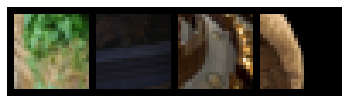

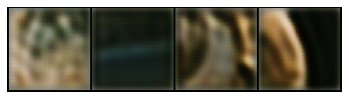

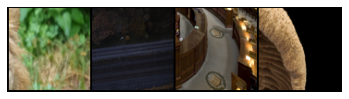

[21/500] Loss_D: 0.1073 Loss_G: 0.0194 D(x): 0.9396 D(G(z)): 0.0390: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[22/500] Loss_D: 0.0911 Loss_G: 0.0191 D(x): 0.9480 D(G(z)): 0.0378: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[23/500] Loss_D: 0.0927 Loss_G: 0.0201 D(x): 0.9672 D(G(z)): 0.0486: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[24/500] Loss_D: 0.1267 Loss_G: 0.0177 D(x): 0.9269 D(G(z)): 0.0406: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[25/500] Loss_D: 0.0665 Loss_G: 0.0167 D(x): 0.9582 D(G(z)): 0.0393: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[26/500] Loss_D: 0.1346 Loss_G: 0.0183 D(x): 0.9790 D(G(z)): 0.0259: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[27/500] Loss_D: 0.1202 Loss_G: 0.0190 D(x): 0.9083 D(G(z)): 0.0249: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[28/500] Loss_D: 0.0731 Loss_G: 0.0191 D(x): 0.9682 D(G(z)): 0.0471: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
[29/500] Loss_D: 0.1121 Loss_G: 0.0172 D(x): 0.9536 D(G(z)): 0.0252: 100%|██████

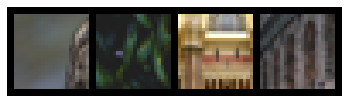

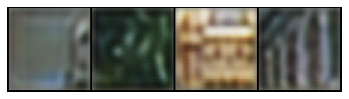

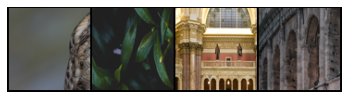

[31/500] Loss_D: 0.2394 Loss_G: 0.0184 D(x): 0.7734 D(G(z)): 0.0163: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[32/500] Loss_D: 0.3383 Loss_G: 0.0175 D(x): 0.9524 D(G(z)): 0.6271: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[33/500] Loss_D: 0.6099 Loss_G: 0.0168 D(x): 0.8951 D(G(z)): 0.1296: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
[34/500] Loss_D: 0.5759 Loss_G: 0.0162 D(x): 0.5524 D(G(z)): 0.2157: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
[35/500] Loss_D: 0.3934 Loss_G: 0.0160 D(x): 0.9437 D(G(z)): 0.1850: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[36/500] Loss_D: 0.4005 Loss_G: 0.0172 D(x): 0.6711 D(G(z)): 0.0474: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[37/500] Loss_D: 0.3258 Loss_G: 0.0157 D(x): 0.7643 D(G(z)): 0.1199: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[38/500] Loss_D: 0.2057 Loss_G: 0.0147 D(x): 0.9248 D(G(z)): 0.0403: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[39/500] Loss_D: 0.1207 Loss_G: 0.0167 D(x): 0.9023 D(G(z)): 0.0141: 100%|██████

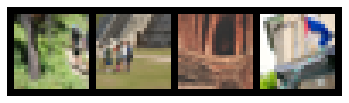

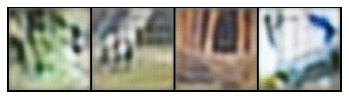

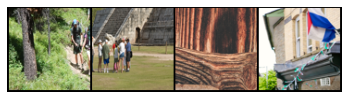

[41/500] Loss_D: 0.1237 Loss_G: 0.0157 D(x): 0.9738 D(G(z)): 0.0290: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[42/500] Loss_D: 0.0660 Loss_G: 0.0169 D(x): 0.9617 D(G(z)): 0.0244: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[43/500] Loss_D: 0.0595 Loss_G: 0.0152 D(x): 0.9689 D(G(z)): 0.0258: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[44/500] Loss_D: 0.0465 Loss_G: 0.0148 D(x): 0.9784 D(G(z)): 0.0182: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[45/500] Loss_D: 0.0273 Loss_G: 0.0156 D(x): 0.9940 D(G(z)): 0.0193: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[46/500] Loss_D: 0.0319 Loss_G: 0.0157 D(x): 0.9876 D(G(z)): 0.0185: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[47/500] Loss_D: 0.0256 Loss_G: 0.0163 D(x): 0.9898 D(G(z)): 0.0147: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[48/500] Loss_D: 0.0240 Loss_G: 0.0152 D(x): 0.9910 D(G(z)): 0.0124: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[49/500] Loss_D: 0.0211 Loss_G: 0.0151 D(x): 0.9914 D(G(z)): 0.0094: 100%|██████

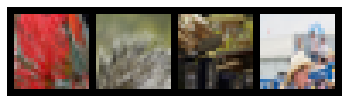

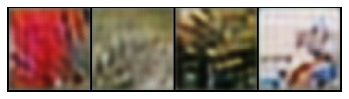

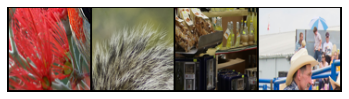

[51/500] Loss_D: 0.0195 Loss_G: 0.0160 D(x): 0.9920 D(G(z)): 0.0107: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[52/500] Loss_D: 0.0116 Loss_G: 0.0141 D(x): 0.9957 D(G(z)): 0.0070: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[53/500] Loss_D: 0.0095 Loss_G: 0.0139 D(x): 0.9950 D(G(z)): 0.0042: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[54/500] Loss_D: 0.0103 Loss_G: 0.0145 D(x): 0.9951 D(G(z)): 0.0052: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[55/500] Loss_D: 0.0077 Loss_G: 0.0147 D(x): 0.9968 D(G(z)): 0.0043: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[56/500] Loss_D: 0.0071 Loss_G: 0.0138 D(x): 0.9972 D(G(z)): 0.0042: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[57/500] Loss_D: 0.0108 Loss_G: 0.0152 D(x): 0.9969 D(G(z)): 0.0074: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[58/500] Loss_D: 0.0094 Loss_G: 0.0146 D(x): 0.9968 D(G(z)): 0.0055: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[59/500] Loss_D: 0.0100 Loss_G: 0.0149 D(x): 0.9947 D(G(z)): 0.0043: 100%|██████

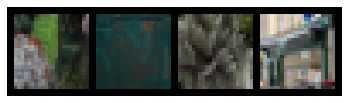

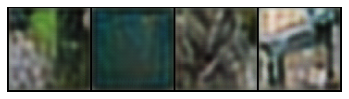

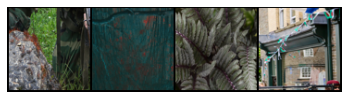

[61/500] Loss_D: 0.0063 Loss_G: 0.0140 D(x): 0.9968 D(G(z)): 0.0031: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[62/500] Loss_D: 0.0054 Loss_G: 0.0136 D(x): 0.9979 D(G(z)): 0.0033: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[63/500] Loss_D: 0.0074 Loss_G: 0.0146 D(x): 0.9970 D(G(z)): 0.0043: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[64/500] Loss_D: 0.0042 Loss_G: 0.0136 D(x): 0.9983 D(G(z)): 0.0025: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[65/500] Loss_D: 0.0064 Loss_G: 0.0140 D(x): 0.9975 D(G(z)): 0.0037: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]
[66/500] Loss_D: 0.0047 Loss_G: 0.0144 D(x): 0.9976 D(G(z)): 0.0022: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[67/500] Loss_D: 0.0041 Loss_G: 0.0144 D(x): 0.9984 D(G(z)): 0.0024: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[68/500] Loss_D: 0.0042 Loss_G: 0.0149 D(x): 0.9982 D(G(z)): 0.0023: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[69/500] Loss_D: 0.0050 Loss_G: 0.0136 D(x): 0.9975 D(G(z)): 0.0023: 100%|██████

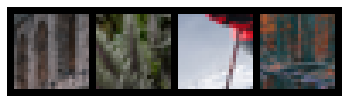

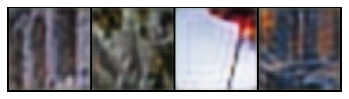

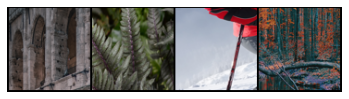

[71/500] Loss_D: 0.0056 Loss_G: 0.0140 D(x): 0.9972 D(G(z)): 0.0028: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[72/500] Loss_D: 0.0057 Loss_G: 0.0132 D(x): 0.9977 D(G(z)): 0.0032: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[73/500] Loss_D: 0.0055 Loss_G: 0.0142 D(x): 0.9964 D(G(z)): 0.0018: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[74/500] Loss_D: 0.0040 Loss_G: 0.0135 D(x): 0.9980 D(G(z)): 0.0020: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[75/500] Loss_D: 0.0063 Loss_G: 0.0145 D(x): 0.9969 D(G(z)): 0.0030: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[76/500] Loss_D: 0.0051 Loss_G: 0.0135 D(x): 0.9978 D(G(z)): 0.0026: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[77/500] Loss_D: 0.0033 Loss_G: 0.0136 D(x): 0.9986 D(G(z)): 0.0019: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[78/500] Loss_D: 0.0037 Loss_G: 0.0141 D(x): 0.9978 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[79/500] Loss_D: 0.0041 Loss_G: 0.0137 D(x): 0.9980 D(G(z)): 0.0021: 100%|██████

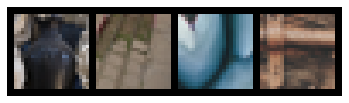

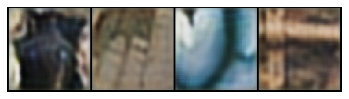

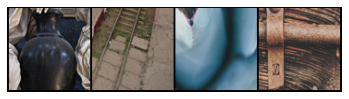

[81/500] Loss_D: 0.0038 Loss_G: 0.0136 D(x): 0.9982 D(G(z)): 0.0019: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[82/500] Loss_D: 0.0032 Loss_G: 0.0139 D(x): 0.9988 D(G(z)): 0.0020: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[83/500] Loss_D: 0.0028 Loss_G: 0.0138 D(x): 0.9989 D(G(z)): 0.0017: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[84/500] Loss_D: 0.0025 Loss_G: 0.0128 D(x): 0.9990 D(G(z)): 0.0015: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[85/500] Loss_D: 0.0051 Loss_G: 0.0138 D(x): 0.9985 D(G(z)): 0.0033: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[86/500] Loss_D: 0.0034 Loss_G: 0.0144 D(x): 0.9989 D(G(z)): 0.0022: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[87/500] Loss_D: 0.0028 Loss_G: 0.0141 D(x): 0.9986 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[88/500] Loss_D: 0.0025 Loss_G: 0.0130 D(x): 0.9989 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[89/500] Loss_D: 0.0028 Loss_G: 0.0138 D(x): 0.9986 D(G(z)): 0.0014: 100%|██████

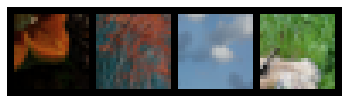

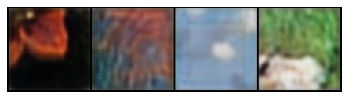

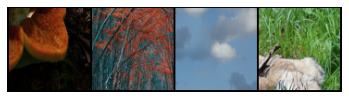

[91/500] Loss_D: 0.0022 Loss_G: 0.0140 D(x): 0.9992 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[92/500] Loss_D: 0.0019 Loss_G: 0.0128 D(x): 0.9992 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[93/500] Loss_D: 0.0044 Loss_G: 0.0134 D(x): 0.9984 D(G(z)): 0.0027: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[94/500] Loss_D: 0.0026 Loss_G: 0.0122 D(x): 0.9989 D(G(z)): 0.0015: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[95/500] Loss_D: 0.0032 Loss_G: 0.0127 D(x): 0.9986 D(G(z)): 0.0017: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[96/500] Loss_D: 0.0040 Loss_G: 0.0127 D(x): 0.9982 D(G(z)): 0.0021: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[97/500] Loss_D: 0.0031 Loss_G: 0.0136 D(x): 0.9988 D(G(z)): 0.0018: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[98/500] Loss_D: 0.0029 Loss_G: 0.0121 D(x): 0.9991 D(G(z)): 0.0018: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[99/500] Loss_D: 0.0025 Loss_G: 0.0130 D(x): 0.9989 D(G(z)): 0.0013: 100%|██████

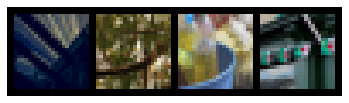

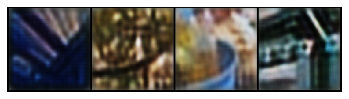

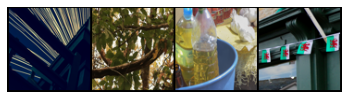

[101/500] Loss_D: 0.0032 Loss_G: 0.0119 D(x): 0.9982 D(G(z)): 0.0013: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[102/500] Loss_D: 0.0025 Loss_G: 0.0128 D(x): 0.9986 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[103/500] Loss_D: 0.0029 Loss_G: 0.0131 D(x): 0.9988 D(G(z)): 0.0016: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[104/500] Loss_D: 0.0019 Loss_G: 0.0135 D(x): 0.9992 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[105/500] Loss_D: 0.0016 Loss_G: 0.0116 D(x): 0.9993 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[106/500] Loss_D: 0.0027 Loss_G: 0.0123 D(x): 0.9991 D(G(z)): 0.0017: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[107/500] Loss_D: 0.0024 Loss_G: 0.0128 D(x): 0.9987 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[108/500] Loss_D: 0.0031 Loss_G: 0.0125 D(x): 0.9980 D(G(z)): 0.0012: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[109/500] Loss_D: 0.0032 Loss_G: 0.0127 D(x): 0.9980 D(G(z)): 0.0011: 10

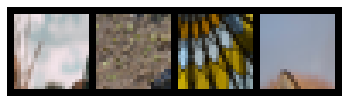

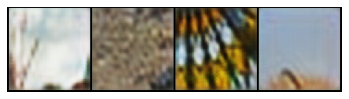

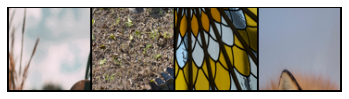

[111/500] Loss_D: 0.0018 Loss_G: 0.0117 D(x): 0.9992 D(G(z)): 0.0010: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[112/500] Loss_D: 0.0016 Loss_G: 0.0122 D(x): 0.9993 D(G(z)): 0.0009: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[113/500] Loss_D: 0.0025 Loss_G: 0.0119 D(x): 0.9991 D(G(z)): 0.0015: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[114/500] Loss_D: 0.0019 Loss_G: 0.0115 D(x): 0.9990 D(G(z)): 0.0009: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[115/500] Loss_D: 0.0020 Loss_G: 0.0116 D(x): 0.9993 D(G(z)): 0.0012: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[116/500] Loss_D: 0.0023 Loss_G: 0.0127 D(x): 0.9986 D(G(z)): 0.0009: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[117/500] Loss_D: 0.0026 Loss_G: 0.0125 D(x): 0.9983 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[118/500] Loss_D: 0.0014 Loss_G: 0.0114 D(x): 0.9994 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[119/500] Loss_D: 0.0023 Loss_G: 0.0120 D(x): 0.9988 D(G(z)): 0.0011: 10

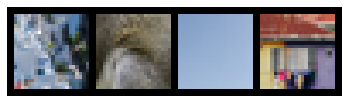

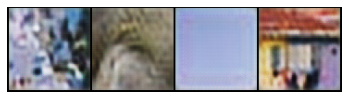

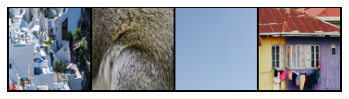

[121/500] Loss_D: 0.0052 Loss_G: 0.0113 D(x): 0.9993 D(G(z)): 0.0026: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[122/500] Loss_D: 0.0030 Loss_G: 0.0119 D(x): 0.9991 D(G(z)): 0.0022: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
[123/500] Loss_D: 0.0033 Loss_G: 0.0119 D(x): 0.9996 D(G(z)): 0.0024: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[124/500] Loss_D: 0.0029 Loss_G: 0.0115 D(x): 0.9991 D(G(z)): 0.0017: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[125/500] Loss_D: 0.0026 Loss_G: 0.0119 D(x): 0.9990 D(G(z)): 0.0015: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[126/500] Loss_D: 0.0023 Loss_G: 0.0120 D(x): 0.9991 D(G(z)): 0.0013: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[127/500] Loss_D: 0.0042 Loss_G: 0.0120 D(x): 0.9973 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[128/500] Loss_D: 0.0022 Loss_G: 0.0123 D(x): 0.9988 D(G(z)): 0.0010: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[129/500] Loss_D: 0.0021 Loss_G: 0.0113 D(x): 0.9990 D(G(z)): 0.0011: 10

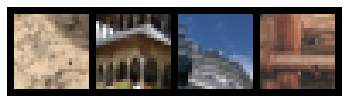

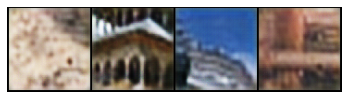

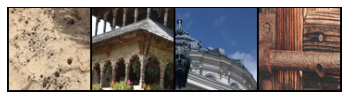

[131/500] Loss_D: 0.0020 Loss_G: 0.0107 D(x): 0.9989 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[132/500] Loss_D: 0.0018 Loss_G: 0.0108 D(x): 0.9993 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[133/500] Loss_D: 0.0025 Loss_G: 0.0124 D(x): 0.9988 D(G(z)): 0.0014: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[134/500] Loss_D: 0.0030 Loss_G: 0.0121 D(x): 0.9981 D(G(z)): 0.0012: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[135/500] Loss_D: 0.0032 Loss_G: 0.0116 D(x): 0.9993 D(G(z)): 0.0023: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[136/500] Loss_D: 0.0016 Loss_G: 0.0122 D(x): 0.9992 D(G(z)): 0.0009: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[137/500] Loss_D: 0.0055 Loss_G: 0.0118 D(x): 0.9993 D(G(z)): 0.0024: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[138/500] Loss_D: 0.0069 Loss_G: 0.0130 D(x): 0.9990 D(G(z)): 0.0041: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[139/500] Loss_D: 0.0017 Loss_G: 0.0118 D(x): 0.9994 D(G(z)): 0.0010: 10

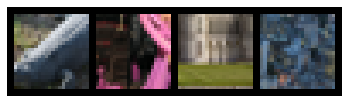

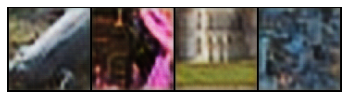

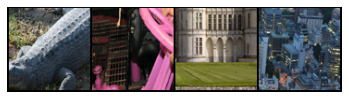

[141/500] Loss_D: 0.0031 Loss_G: 0.0122 D(x): 0.9982 D(G(z)): 0.0013: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[142/500] Loss_D: 0.0023 Loss_G: 0.0107 D(x): 0.9988 D(G(z)): 0.0010: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[143/500] Loss_D: 0.0014 Loss_G: 0.0120 D(x): 0.9995 D(G(z)): 0.0009: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[144/500] Loss_D: 0.0019 Loss_G: 0.0107 D(x): 0.9990 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[145/500] Loss_D: 0.0023 Loss_G: 0.0121 D(x): 0.9988 D(G(z)): 0.0010: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[146/500] Loss_D: 0.0012 Loss_G: 0.0104 D(x): 0.9996 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[147/500] Loss_D: 0.0025 Loss_G: 0.0118 D(x): 0.9988 D(G(z)): 0.0012: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[148/500] Loss_D: 0.0028 Loss_G: 0.0114 D(x): 0.9981 D(G(z)): 0.0008: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
[149/500] Loss_D: 0.0021 Loss_G: 0.0117 D(x): 0.9987 D(G(z)): 0.0008: 10

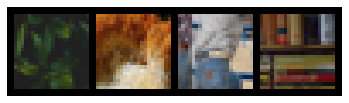

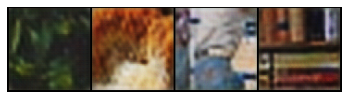

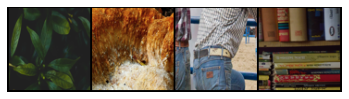

[151/500] Loss_D: 0.0020 Loss_G: 0.0116 D(x): 0.9992 D(G(z)): 0.0011: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[152/500] Loss_D: 0.0015 Loss_G: 0.0112 D(x): 0.9991 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[153/500] Loss_D: 0.0022 Loss_G: 0.0119 D(x): 0.9991 D(G(z)): 0.0012: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[154/500] Loss_D: 0.0011 Loss_G: 0.0107 D(x): 0.9995 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[155/500] Loss_D: 0.0013 Loss_G: 0.0109 D(x): 0.9992 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[156/500] Loss_D: 0.0012 Loss_G: 0.0122 D(x): 0.9994 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[157/500] Loss_D: 0.0016 Loss_G: 0.0117 D(x): 0.9990 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[158/500] Loss_D: 0.0009 Loss_G: 0.0112 D(x): 0.9995 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[159/500] Loss_D: 0.0010 Loss_G: 0.0105 D(x): 0.9995 D(G(z)): 0.0004: 10

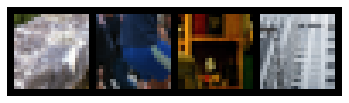

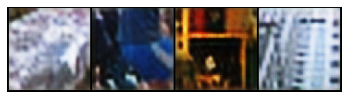

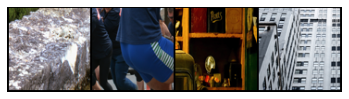

[161/500] Loss_D: 0.0008 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[162/500] Loss_D: 0.0011 Loss_G: 0.0115 D(x): 0.9994 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[163/500] Loss_D: 0.0009 Loss_G: 0.0111 D(x): 0.9995 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[164/500] Loss_D: 0.0009 Loss_G: 0.0106 D(x): 0.9996 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[165/500] Loss_D: 0.0022 Loss_G: 0.0111 D(x): 0.9983 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[166/500] Loss_D: 0.0007 Loss_G: 0.0115 D(x): 0.9997 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[167/500] Loss_D: 0.0014 Loss_G: 0.0114 D(x): 0.9992 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[168/500] Loss_D: 0.0010 Loss_G: 0.0109 D(x): 0.9995 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[169/500] Loss_D: 0.0007 Loss_G: 0.0106 D(x): 0.9997 D(G(z)): 0.0004: 10

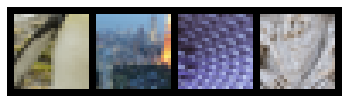

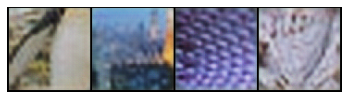

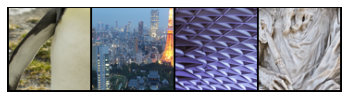

[171/500] Loss_D: 0.0007 Loss_G: 0.0108 D(x): 0.9996 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[172/500] Loss_D: 0.0010 Loss_G: 0.0108 D(x): 0.9995 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[173/500] Loss_D: 0.0009 Loss_G: 0.0107 D(x): 0.9997 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[174/500] Loss_D: 0.0011 Loss_G: 0.0103 D(x): 0.9992 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[175/500] Loss_D: 0.0007 Loss_G: 0.0110 D(x): 0.9997 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[176/500] Loss_D: 0.0007 Loss_G: 0.0106 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[177/500] Loss_D: 0.0010 Loss_G: 0.0118 D(x): 0.9996 D(G(z)): 0.0006: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[178/500] Loss_D: 0.0008 Loss_G: 0.0108 D(x): 0.9996 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[179/500] Loss_D: 0.0007 Loss_G: 0.0104 D(x): 0.9997 D(G(z)): 0.0004: 10

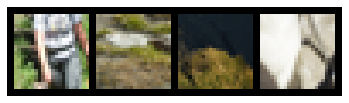

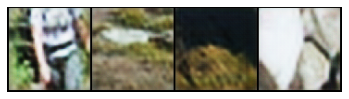

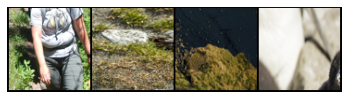

[181/500] Loss_D: 0.0008 Loss_G: 0.0106 D(x): 0.9996 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[182/500] Loss_D: 0.0009 Loss_G: 0.0099 D(x): 0.9995 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[183/500] Loss_D: 0.0010 Loss_G: 0.0108 D(x): 0.9994 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[184/500] Loss_D: 0.0010 Loss_G: 0.0110 D(x): 0.9997 D(G(z)): 0.0007: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[185/500] Loss_D: 0.0007 Loss_G: 0.0112 D(x): 0.9997 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[186/500] Loss_D: 0.0009 Loss_G: 0.0119 D(x): 0.9997 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[187/500] Loss_D: 0.0006 Loss_G: 0.0112 D(x): 0.9997 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[188/500] Loss_D: 0.0006 Loss_G: 0.0102 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[189/500] Loss_D: 0.0006 Loss_G: 0.0115 D(x): 0.9997 D(G(z)): 0.0003: 10

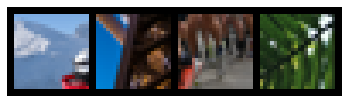

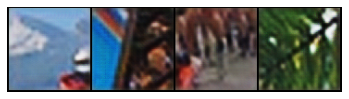

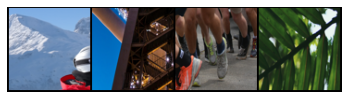

[191/500] Loss_D: 0.0009 Loss_G: 0.0113 D(x): 0.9996 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[192/500] Loss_D: 0.0008 Loss_G: 0.0114 D(x): 0.9998 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[193/500] Loss_D: 0.0005 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[194/500] Loss_D: 0.0012 Loss_G: 0.0116 D(x): 0.9992 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[195/500] Loss_D: 0.0005 Loss_G: 0.0103 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[196/500] Loss_D: 0.0006 Loss_G: 0.0106 D(x): 0.9998 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[197/500] Loss_D: 0.0006 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[198/500] Loss_D: 0.0005 Loss_G: 0.0125 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[199/500] Loss_D: 0.0006 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0003: 10

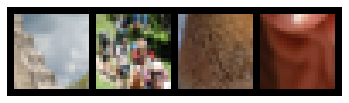

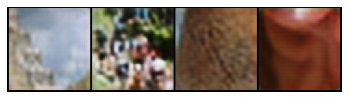

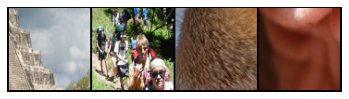

[201/500] Loss_D: 0.0007 Loss_G: 0.0118 D(x): 0.9996 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[202/500] Loss_D: 0.0007 Loss_G: 0.0110 D(x): 0.9996 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[203/500] Loss_D: 0.0005 Loss_G: 0.0102 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[204/500] Loss_D: 0.0009 Loss_G: 0.0112 D(x): 0.9995 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[205/500] Loss_D: 0.0005 Loss_G: 0.0102 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[206/500] Loss_D: 0.0006 Loss_G: 0.0116 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
[207/500] Loss_D: 0.0007 Loss_G: 0.0108 D(x): 0.9996 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[208/500] Loss_D: 0.0006 Loss_G: 0.0120 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[209/500] Loss_D: 0.0008 Loss_G: 0.0108 D(x): 0.9996 D(G(z)): 0.0004: 10

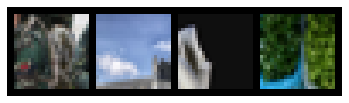

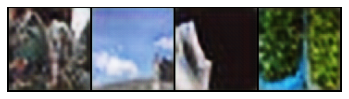

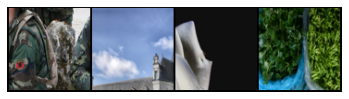

[211/500] Loss_D: 0.0005 Loss_G: 0.0106 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[212/500] Loss_D: 0.0004 Loss_G: 0.0105 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[213/500] Loss_D: 0.0005 Loss_G: 0.0110 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[214/500] Loss_D: 0.0005 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[215/500] Loss_D: 0.0006 Loss_G: 0.0108 D(x): 0.9996 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[216/500] Loss_D: 0.0004 Loss_G: 0.0104 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[217/500] Loss_D: 0.0008 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[218/500] Loss_D: 0.0005 Loss_G: 0.0104 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[219/500] Loss_D: 0.0008 Loss_G: 0.0103 D(x): 0.9996 D(G(z)): 0.0004: 10

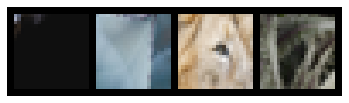

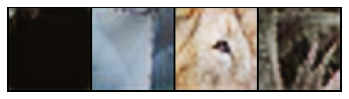

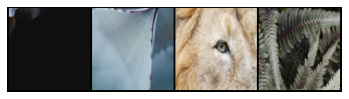

[221/500] Loss_D: 0.0005 Loss_G: 0.0114 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[222/500] Loss_D: 0.0004 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[223/500] Loss_D: 0.0006 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
[224/500] Loss_D: 0.0006 Loss_G: 0.0101 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[225/500] Loss_D: 0.0005 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[226/500] Loss_D: 0.0004 Loss_G: 0.0108 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[227/500] Loss_D: 0.0003 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[228/500] Loss_D: 0.0004 Loss_G: 0.0111 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[229/500] Loss_D: 0.0004 Loss_G: 0.0109 D(x): 0.9998 D(G(z)): 0.0002: 10

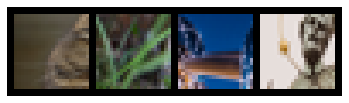

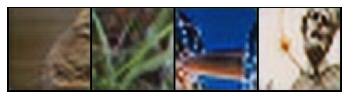

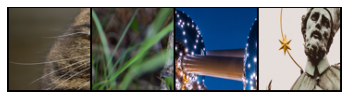

[231/500] Loss_D: 0.0004 Loss_G: 0.0108 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[232/500] Loss_D: 0.0005 Loss_G: 0.0110 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[233/500] Loss_D: 0.0008 Loss_G: 0.0119 D(x): 0.9994 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[234/500] Loss_D: 0.0011 Loss_G: 0.0111 D(x): 0.9992 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[235/500] Loss_D: 0.0006 Loss_G: 0.0109 D(x): 0.9998 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[236/500] Loss_D: 0.0004 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[237/500] Loss_D: 0.0005 Loss_G: 0.0111 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[238/500] Loss_D: 0.0006 Loss_G: 0.0103 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[239/500] Loss_D: 0.0004 Loss_G: 0.0110 D(x): 0.9998 D(G(z)): 0.0002: 10

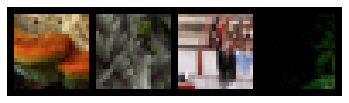

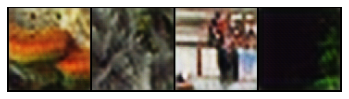

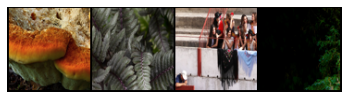

[241/500] Loss_D: 0.0007 Loss_G: 0.0107 D(x): 0.9997 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[242/500] Loss_D: 0.0004 Loss_G: 0.0110 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[243/500] Loss_D: 0.0006 Loss_G: 0.0115 D(x): 0.9998 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[244/500] Loss_D: 0.0007 Loss_G: 0.0102 D(x): 0.9996 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[245/500] Loss_D: 0.0004 Loss_G: 0.0106 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[246/500] Loss_D: 0.0005 Loss_G: 0.0106 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[247/500] Loss_D: 0.0006 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[248/500] Loss_D: 0.0005 Loss_G: 0.0114 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[249/500] Loss_D: 0.0005 Loss_G: 0.0103 D(x): 0.9997 D(G(z)): 0.0002: 10

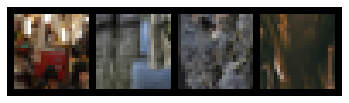

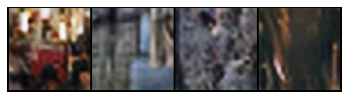

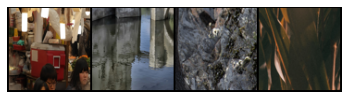

[251/500] Loss_D: 0.0004 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[252/500] Loss_D: 0.0004 Loss_G: 0.0102 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[253/500] Loss_D: 0.0005 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[254/500] Loss_D: 0.0007 Loss_G: 0.0109 D(x): 0.9995 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[255/500] Loss_D: 0.0005 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[256/500] Loss_D: 0.0006 Loss_G: 0.0106 D(x): 0.9997 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[257/500] Loss_D: 0.0008 Loss_G: 0.0112 D(x): 0.9997 D(G(z)): 0.0005: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[258/500] Loss_D: 0.0003 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[259/500] Loss_D: 0.0005 Loss_G: 0.0111 D(x): 0.9997 D(G(z)): 0.0002: 10

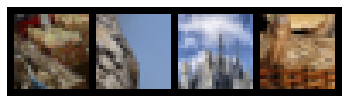

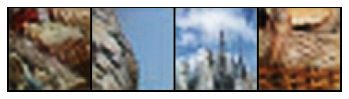

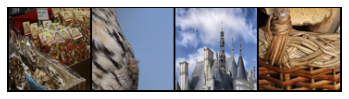

[261/500] Loss_D: 0.0003 Loss_G: 0.0109 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[262/500] Loss_D: 0.0006 Loss_G: 0.0116 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[263/500] Loss_D: 0.0005 Loss_G: 0.0104 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[264/500] Loss_D: 0.0004 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[265/500] Loss_D: 0.0004 Loss_G: 0.0101 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[266/500] Loss_D: 0.0003 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[267/500] Loss_D: 0.0004 Loss_G: 0.0113 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[268/500] Loss_D: 0.0003 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[269/500] Loss_D: 0.0003 Loss_G: 0.0114 D(x): 0.9998 D(G(z)): 0.0002: 10

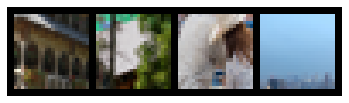

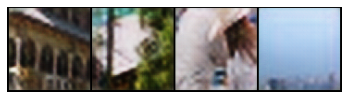

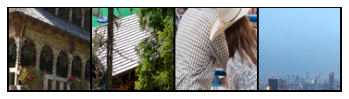

[271/500] Loss_D: 0.0006 Loss_G: 0.0110 D(x): 0.9996 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[272/500] Loss_D: 0.0004 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[273/500] Loss_D: 0.0003 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[274/500] Loss_D: 0.0003 Loss_G: 0.0115 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[275/500] Loss_D: 0.0004 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[276/500] Loss_D: 0.0005 Loss_G: 0.0104 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[277/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[278/500] Loss_D: 0.0002 Loss_G: 0.0093 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[279/500] Loss_D: 0.0003 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0002: 10

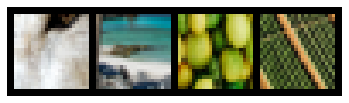

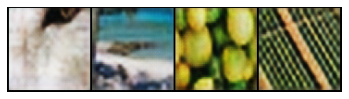

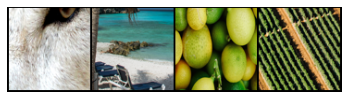

[281/500] Loss_D: 0.0004 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[282/500] Loss_D: 0.0003 Loss_G: 0.0103 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[283/500] Loss_D: 0.0003 Loss_G: 0.0103 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[284/500] Loss_D: 0.0003 Loss_G: 0.0107 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[285/500] Loss_D: 0.0005 Loss_G: 0.0107 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[286/500] Loss_D: 0.0004 Loss_G: 0.0110 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[287/500] Loss_D: 0.0004 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[288/500] Loss_D: 0.0003 Loss_G: 0.0095 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[289/500] Loss_D: 0.0003 Loss_G: 0.0096 D(x): 0.9998 D(G(z)): 0.0002: 10

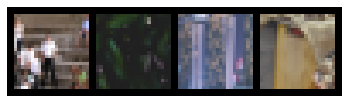

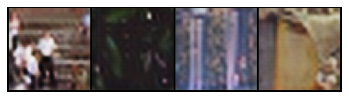

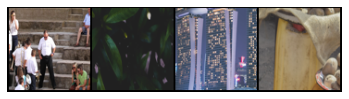

[291/500] Loss_D: 0.0005 Loss_G: 0.0108 D(x): 0.9998 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[292/500] Loss_D: 0.0003 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[293/500] Loss_D: 0.0004 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[294/500] Loss_D: 0.0003 Loss_G: 0.0100 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[295/500] Loss_D: 0.0004 Loss_G: 0.0099 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[296/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
[297/500] Loss_D: 0.0004 Loss_G: 0.0109 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[298/500] Loss_D: 0.0003 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[299/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 10

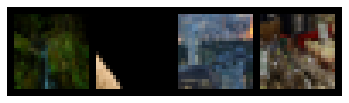

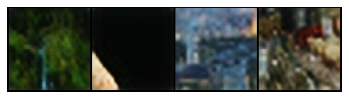

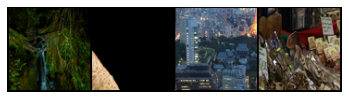

[301/500] Loss_D: 0.0004 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[302/500] Loss_D: 0.0002 Loss_G: 0.0107 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[303/500] Loss_D: 0.0003 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[304/500] Loss_D: 0.0003 Loss_G: 0.0110 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[305/500] Loss_D: 0.0002 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[306/500] Loss_D: 0.0007 Loss_G: 0.0108 D(x): 0.9997 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[307/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[308/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[309/500] Loss_D: 0.0008 Loss_G: 0.0111 D(x): 0.9998 D(G(z)): 0.0005: 10

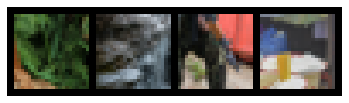

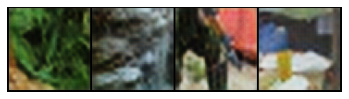

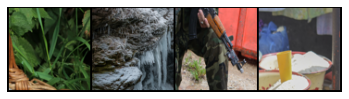

[311/500] Loss_D: 0.0003 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[312/500] Loss_D: 0.0002 Loss_G: 0.0094 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[313/500] Loss_D: 0.0002 Loss_G: 0.0105 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[314/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[315/500] Loss_D: 0.0003 Loss_G: 0.0104 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[316/500] Loss_D: 0.0002 Loss_G: 0.0093 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[317/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[318/500] Loss_D: 0.0004 Loss_G: 0.0103 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[319/500] Loss_D: 0.0004 Loss_G: 0.0097 D(x): 0.9997 D(G(z)): 0.0001: 10

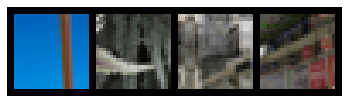

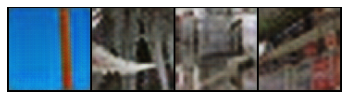

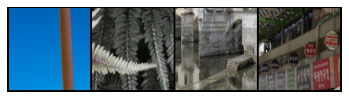

[321/500] Loss_D: 0.0004 Loss_G: 0.0098 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[322/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[323/500] Loss_D: 0.0003 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[324/500] Loss_D: 0.0002 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[325/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[326/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[327/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[328/500] Loss_D: 0.0002 Loss_G: 0.0094 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[329/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 10

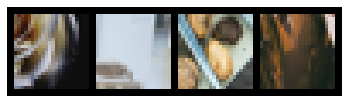

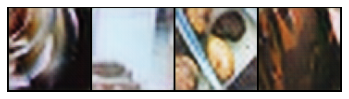

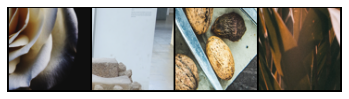

[331/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[332/500] Loss_D: 0.0003 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[333/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[334/500] Loss_D: 0.0002 Loss_G: 0.0111 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[335/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[336/500] Loss_D: 0.0003 Loss_G: 0.0104 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[337/500] Loss_D: 0.0003 Loss_G: 0.0103 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[338/500] Loss_D: 0.0002 Loss_G: 0.0093 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[339/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 10

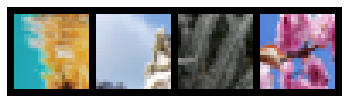

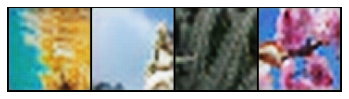

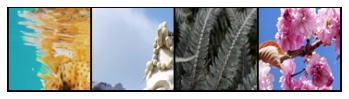

[341/500] Loss_D: 0.0004 Loss_G: 0.0108 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[342/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[343/500] Loss_D: 0.0002 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[344/500] Loss_D: 0.0002 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[345/500] Loss_D: 0.0006 Loss_G: 0.0115 D(x): 0.9999 D(G(z)): 0.0004: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[346/500] Loss_D: 0.0002 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[347/500] Loss_D: 0.0003 Loss_G: 0.0114 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[348/500] Loss_D: 0.0003 Loss_G: 0.0111 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[349/500] Loss_D: 0.0003 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0001: 10

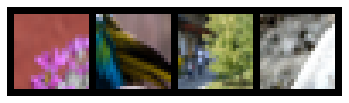

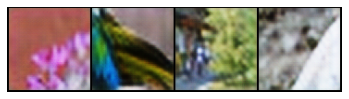

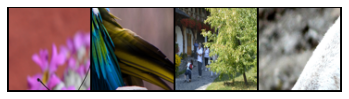

[351/500] Loss_D: 0.0003 Loss_G: 0.0106 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[352/500] Loss_D: 0.0003 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[353/500] Loss_D: 0.0003 Loss_G: 0.0115 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[354/500] Loss_D: 0.0003 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[355/500] Loss_D: 0.0004 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[356/500] Loss_D: 0.0002 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[357/500] Loss_D: 0.0004 Loss_G: 0.0106 D(x): 0.9998 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[358/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[359/500] Loss_D: 0.0002 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0001: 10

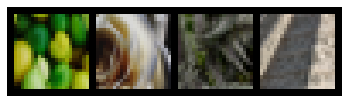

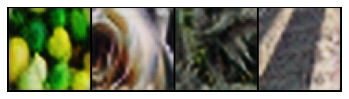

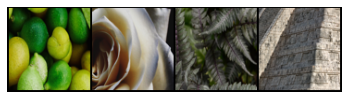

[361/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]
[362/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[363/500] Loss_D: 0.0002 Loss_G: 0.0096 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[364/500] Loss_D: 0.0005 Loss_G: 0.0118 D(x): 0.9997 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[365/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[366/500] Loss_D: 0.0003 Loss_G: 0.0089 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[367/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[368/500] Loss_D: 0.0004 Loss_G: 0.0109 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[369/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 10

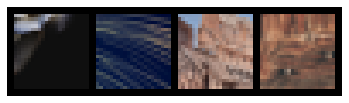

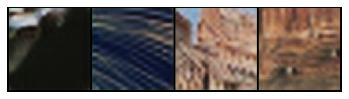

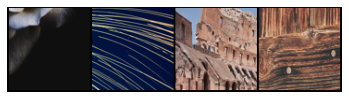

[371/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[372/500] Loss_D: 0.0002 Loss_G: 0.0091 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[373/500] Loss_D: 0.0002 Loss_G: 0.0112 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]
[374/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[375/500] Loss_D: 0.0002 Loss_G: 0.0114 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[376/500] Loss_D: 0.0001 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[377/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[378/500] Loss_D: 0.0001 Loss_G: 0.0105 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[379/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 10

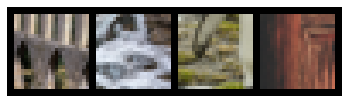

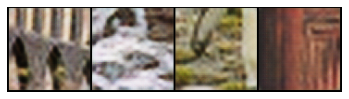

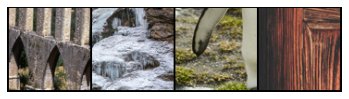

[381/500] Loss_D: 0.0005 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0003: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[382/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[383/500] Loss_D: 0.0003 Loss_G: 0.0097 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[384/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[385/500] Loss_D: 0.0003 Loss_G: 0.0104 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
[386/500] Loss_D: 0.0005 Loss_G: 0.0094 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[387/500] Loss_D: 0.0002 Loss_G: 0.0109 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[388/500] Loss_D: 0.0003 Loss_G: 0.0119 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[389/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0002: 10

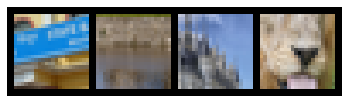

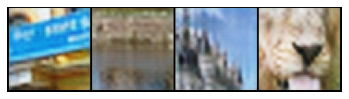

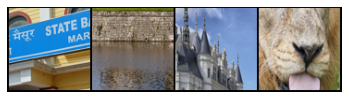

[391/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[392/500] Loss_D: 0.0003 Loss_G: 0.0111 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[393/500] Loss_D: 0.0002 Loss_G: 0.0105 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[394/500] Loss_D: 0.0004 Loss_G: 0.0103 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[395/500] Loss_D: 0.0003 Loss_G: 0.0102 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[396/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[397/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[398/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[399/500] Loss_D: 0.0006 Loss_G: 0.0107 D(x): 0.9998 D(G(z)): 0.0003: 10

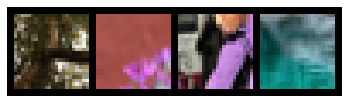

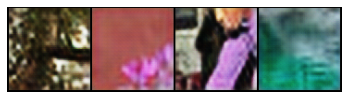

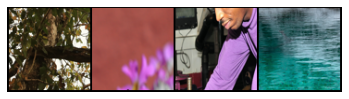

[401/500] Loss_D: 0.0001 Loss_G: 0.0097 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[402/500] Loss_D: 0.0002 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[403/500] Loss_D: 0.0001 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[404/500] Loss_D: 0.0001 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[405/500] Loss_D: 0.0004 Loss_G: 0.0104 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[406/500] Loss_D: 0.0001 Loss_G: 0.0091 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
[407/500] Loss_D: 0.0001 Loss_G: 0.0105 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]
[408/500] Loss_D: 0.0001 Loss_G: 0.0093 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[409/500] Loss_D: 0.0001 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 10

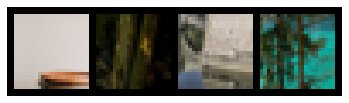

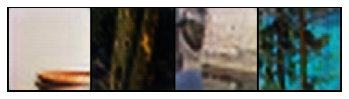

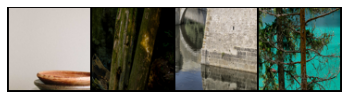

[411/500] Loss_D: 0.0002 Loss_G: 0.0107 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[412/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[413/500] Loss_D: 0.0004 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[414/500] Loss_D: 0.0002 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[415/500] Loss_D: 0.0001 Loss_G: 0.0107 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[416/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[417/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[418/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[419/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 10

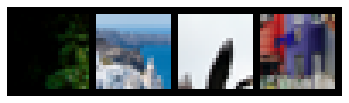

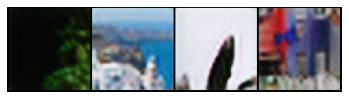

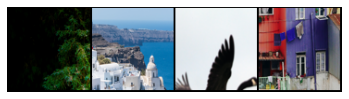

[421/500] Loss_D: 0.0001 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[422/500] Loss_D: 0.0001 Loss_G: 0.0104 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[423/500] Loss_D: 0.0002 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[424/500] Loss_D: 0.0003 Loss_G: 0.0105 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[425/500] Loss_D: 0.0001 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[426/500] Loss_D: 0.0001 Loss_G: 0.0094 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[427/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[428/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[429/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 10

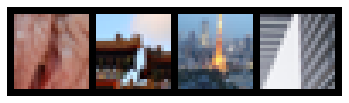

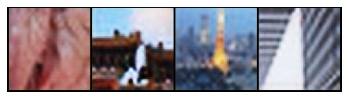

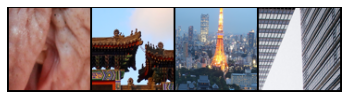

[431/500] Loss_D: 0.0002 Loss_G: 0.0116 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
[432/500] Loss_D: 0.0001 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[433/500] Loss_D: 0.0002 Loss_G: 0.0111 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[434/500] Loss_D: 0.0001 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[435/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[436/500] Loss_D: 0.0002 Loss_G: 0.0096 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[437/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[438/500] Loss_D: 0.0002 Loss_G: 0.0111 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[439/500] Loss_D: 0.0001 Loss_G: 0.0106 D(x): 1.0000 D(G(z)): 0.0001: 10

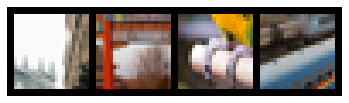

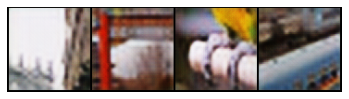

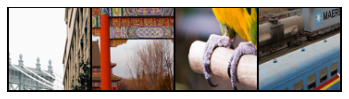

[441/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
[442/500] Loss_D: 0.0001 Loss_G: 0.0096 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
[443/500] Loss_D: 0.0001 Loss_G: 0.0092 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[444/500] Loss_D: 0.0001 Loss_G: 0.0102 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[445/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[446/500] Loss_D: 0.0002 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
[447/500] Loss_D: 0.0001 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[448/500] Loss_D: 0.0002 Loss_G: 0.0098 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[449/500] Loss_D: 0.0001 Loss_G: 0.0096 D(x): 1.0000 D(G(z)): 0.0001: 10

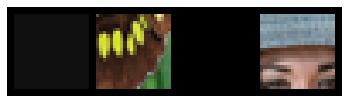

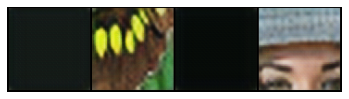

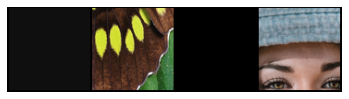

[451/500] Loss_D: 0.0003 Loss_G: 0.0097 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[452/500] Loss_D: 0.0002 Loss_G: 0.0094 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[453/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[454/500] Loss_D: 0.0003 Loss_G: 0.0095 D(x): 0.9998 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[455/500] Loss_D: 0.0001 Loss_G: 0.0098 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[456/500] Loss_D: 0.0002 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[457/500] Loss_D: 0.0002 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[458/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[459/500] Loss_D: 0.0002 Loss_G: 0.0092 D(x): 0.9999 D(G(z)): 0.0001: 10

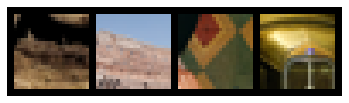

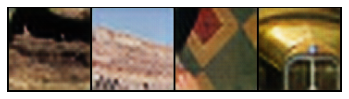

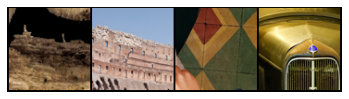

[461/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
[462/500] Loss_D: 0.0001 Loss_G: 0.0101 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[463/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[464/500] Loss_D: 0.0001 Loss_G: 0.0093 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[465/500] Loss_D: 0.0004 Loss_G: 0.0101 D(x): 0.9997 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[466/500] Loss_D: 0.0001 Loss_G: 0.0096 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[467/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[468/500] Loss_D: 0.0001 Loss_G: 0.0097 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
[469/500] Loss_D: 0.0001 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0000: 10

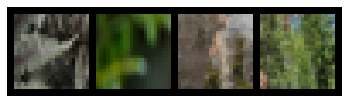

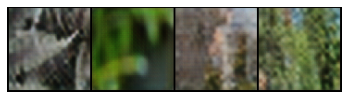

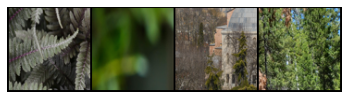

[471/500] Loss_D: 0.0001 Loss_G: 0.0102 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
[472/500] Loss_D: 0.0003 Loss_G: 0.0107 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[473/500] Loss_D: 0.0001 Loss_G: 0.0097 D(x): 0.9999 D(G(z)): 0.0000: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[474/500] Loss_D: 0.0001 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[475/500] Loss_D: 0.0002 Loss_G: 0.0108 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[476/500] Loss_D: 0.0002 Loss_G: 0.0096 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
[477/500] Loss_D: 0.0002 Loss_G: 0.0097 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[478/500] Loss_D: 0.0001 Loss_G: 0.0108 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
[479/500] Loss_D: 0.0001 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0001: 10

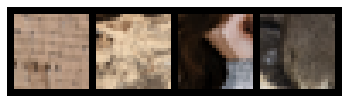

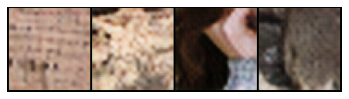

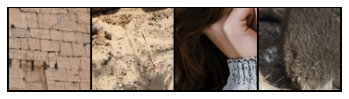

[481/500] Loss_D: 0.0001 Loss_G: 0.0097 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
[482/500] Loss_D: 0.0001 Loss_G: 0.0101 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[483/500] Loss_D: 0.0001 Loss_G: 0.0105 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[484/500] Loss_D: 0.0001 Loss_G: 0.0090 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[485/500] Loss_D: 0.0001 Loss_G: 0.0106 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[486/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]
[487/500] Loss_D: 0.0001 Loss_G: 0.0104 D(x): 0.9999 D(G(z)): 0.0000: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[488/500] Loss_D: 0.0001 Loss_G: 0.0098 D(x): 1.0000 D(G(z)): 0.0000: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]
[489/500] Loss_D: 0.0001 Loss_G: 0.0093 D(x): 1.0000 D(G(z)): 0.0001: 10

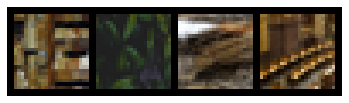

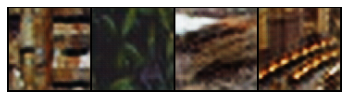

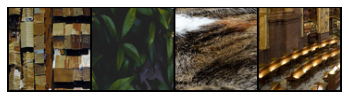

[491/500] Loss_D: 0.0001 Loss_G: 0.0095 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]
[492/500] Loss_D: 0.0001 Loss_G: 0.0096 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[493/500] Loss_D: 0.0001 Loss_G: 0.0091 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[494/500] Loss_D: 0.0002 Loss_G: 0.0103 D(x): 0.9999 D(G(z)): 0.0002: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
[495/500] Loss_D: 0.0001 Loss_G: 0.0099 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[496/500] Loss_D: 0.0002 Loss_G: 0.0100 D(x): 0.9999 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
[497/500] Loss_D: 0.0001 Loss_G: 0.0098 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
[498/500] Loss_D: 0.0001 Loss_G: 0.0096 D(x): 1.0000 D(G(z)): 0.0001: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
[499/500] Loss_D: 0.0001 Loss_G: 0.0098 D(x): 1.0000 D(G(z)): 0.0000: 10

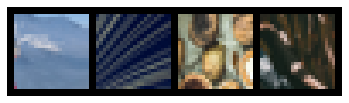

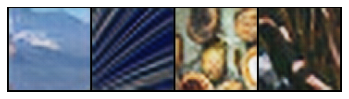

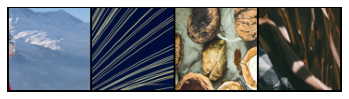

In [7]:
def train_fn(disc, gen, loader, generator_criterion, opt_disc, opt_gen, epoch):
    train_bar = tqdm(loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}        
    
    gen.train()
    disc.train()

    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()

        # Update Discriminator Network
        fake_img = gen(z)

        disc.zero_grad()
        real_out = disc(real_img).mean()
        fake_out = disc(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        opt_disc.step()

         # Update Generator network
        fake_img = gen(z)
        fake_out = disc(fake_img).mean()

        gen.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = gen(z)
        fake_out = disc(fake_img).mean()

        opt_gen.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    gen.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    torch.save(gen.state_dict(), "super_res_gen.pth")

    if epoch % 10 == 0 or epoch == NUM_EPOCHS - 1:
        show_tensor_images(z * 2 - 1)
        show_tensor_images(fake_img.to(fake_img.dtype) * 2 - 1)
        show_tensor_images(real_img * 2 - 1)
        mean_loss = 0.0


def main():
    disc = Discriminator().to(DEVICE)
    gen = Generator(UPSCALE_FACTOR).to(DEVICE)
    generator_criterion = GeneratorLoss().to(DEVICE)

    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE)

    results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

    train_dataset = TrainDatasetFromFolder(TARGET_DIR, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
    train_loader = DataLoader(dataset=train_dataset, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, generator_criterion, opt_disc, opt_gen, epoch)

if __name__ == "__main__":
    main()